In [1]:
import numpy as np
import math

<img src = 'algo_ekf.jpg'>
<img src = 'probstatement_ekf.jpg'>

In [2]:
# This function converts/wraps any angle in radian between -pi and pi
def wrapToPi(x):
    return x-2*math.pi*math.floor(x/(2*math.pi)+0.5) 
   
#angle_rad = angle_rad - 2*pi*floor( (angle_rad+pi)/(2*pi) );
    
# This is the real data.    
class groundTruth:
    def __init__(self,x,y):
        self.x = x
        self.y = y

# System model        
class system:
    def __init__(self,A,B,f,H,h,Q,R):
        self.A = A
        self.B = B
        self.f = f
        self.H = H
        self.h = h
        self.Q = Q
        self.R = R

# Initial data        
class initial:
    def __init__(self,x,Sigma):
        self.x = x
        self.Sigma = Sigma

class ekf:
    def __init__(self,system,init):
        self.A = system.A
        self.B = system.B
        self.f = system.f
        self.H = system.H
        self.Q = system.Q
        self.R = system.R
        self.h = system.h
        
        self.x = init.x
        self.Sigma = init.Sigma
    
    def prediction(self): # Prediction step
        self.x_pred = self.f(self.x)
        self.Sigma_pred = (self.A)@(self.Sigma)@((self.A).transpose())+self.Q
        self.z_hat = self.h(self.x_pred)
    
    def correction(self,z): # Correction step
        H_ = self.H(self.x_pred)
        self.v = z - self.z_hat
        self.v[1] = wrapToPi(self.v[1])
        
        self.S = (H_)@(self.Sigma_pred)@(H_.transpose())+self.R
        self.K = (self.Sigma_pred)@(H_.transpose())@(np.linalg.inv(self.S))
        self.x = self.x_pred+(self.K)@(self.v)
        
        I = np.eye(len(self.x))
        self.Sigma = (I-self.K@H_)@(self.Sigma_pred)@((I-self.K@H_).transpose())+self.K@self.R@self.K.transpose()
        # Written in Joseph form as it's numerically stable
        

In [3]:
# Earlier wrote in the form of lambda functions but they
# had some issue with the shape of out array.
def f(x):
    array = np.zeros((2,1))
    array[0] = x[0]
    array[1] = x[1]
    return array

def H(x):
    array = np.zeros((2,2))
    temp = math.sqrt(x[0]**2+x[1]**2)
    array[0][0] = x[0]/temp
    array[0][1] = x[1]/temp
    array[1][0] = x[1]/temp**2
    array[1][1] = -x[0]/temp**2
    return array
    
def h(x):
    array = np.zeros((2,1))
    array[0] = math.sqrt(x[0]**2+x[1]**2)
    array[1] = math.atan2(x[0],x[1])
    return array

# Given Initial parameters
A = np.identity(2)
B = np.array([])
Q = np.identity(2)*10**-3
R = np.diag([0.05**2,0.01**2])
L = np.linalg.cholesky(R)

# Generating true data
xdata = np.linspace(-5,5,100)
ydata = np.array([math.sin(i)+3 for i in xdata])
gt = groundTruth(xdata,ydata)

# Creating sensor data by adding random noise to the data.
# Sensor data is stored in the form of range and bearing data

z = np.zeros((2,100))
for i in range(100):
    noise = L@np.random.rand(2,1)
    z[0,i] = math.sqrt((gt.x[i])**2+(gt.y[i])**2)+noise[0]
    z[1,i] = math.atan2(gt.x[i],gt.y[i])+noise[1]

# Visualization purpose. Converted sensor data into x and y coordinate data
z_ = np.zeros((2,100))
for j in range(100):
    z_[0,j] = z[0,j]*math.sin(z[1,j])
    z_[1,j] = z[0,j]*math.cos(z[1,j])

# Given initial data is assumed to be taken from the sensors.    
x = np.zeros((2,1))
x[0] = z[0,0]*math.sin(z[1,0])
x[1] = z[0,0]*math.cos(z[1,0])
Sigma = np.identity(2)


                         

In [4]:
sys = system(A,B,f,H,h,Q,R)
init = initial(x,Sigma)

In [5]:
filter = ekf(sys,init)

# These array stores
xfil = np.zeros((2,100))
xfil[0,0] = z[0,0]*math.sin(z[1,0])
xfil[1,0] = z[0,0]*math.cos(z[1,0])


for i in range(100):
    z_temp = np.zeros((2,1))
    z_temp[0] = z[0,i]
    z_temp[1] = z[1,i]
    filter.prediction()
    filter.correction(z_temp)
    xfil[0,i] = filter.x[0]
    xfil[1,i] = filter.x[1]

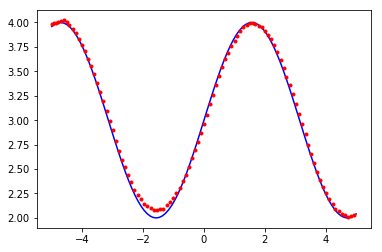

In [10]:
import matplotlib.pyplot as plt
plt.plot(gt.x,gt.y,color='blue')
plt.plot(xfil[0,:],xfil[1,:],'.',color='r')

plt.plot()
plt.show()

Comparison of ground truth and Kalman filtered data

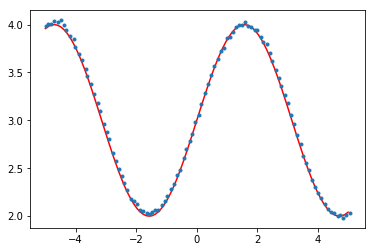

In [11]:
plt.plot(gt.x,gt.y,color='r')
plt.plot(z_[0,:],z_[1,:],'.')

Comparison of actual sensor data and Kalman filtered data

Useful links :- <br>
EKF from the slam course :  https://www.youtube.com/watch?v=mYAsKbwqGv0&list=PLX2gX-ftPVXU3oUFNATxGXY90AULiqnWT&index=18. Start from 33 minutes<br>

Second lecture, EECS course by University of Michigan - http://robots.engin.umich.edu/mobilerobotics/media/Slides/02_kalman_filtering.pdf

